In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

In [208]:
# Import et concaténation des deux fichiers source
path = "../Data/"
df_source1 = pd.read_csv(path + "Sleep_health_and_lifestyle_dataset.csv")
df_source2 = pd.read_csv(path + "Sleep_health_and_lifestyle_dataset_part_2.csv")
df = pd.concat([df_source1, df_source2])

# Person ID 374 est un doublon
df.drop(index=373, inplace=True)

# On recrée l'index
df.index = df["Person ID"].values

# On retire l'ID du sujet qui ne nous sera pas utile
df.drop(columns="Person ID", inplace=True)


In [209]:
# Modification des noms de colonne, on supprime les espaces
mapper = {
    "Sleep Duration" : "SleepDuration",
    "Quality of Sleep" : "QualitySleep",
    "Physical Activity Level" : "PhysicalActivityLevel",
    "Stress Level" : "StressLevel",
    "BMI Category" : "BMI_Category",
    "Blood Pressure" : "BloodPressure",
    "Heart Rate" : "HeartRate",
    "Daily Steps" : "DailySteps",
    "Sleep Disorder" : "SleepDisorder"
}
df.rename(columns=mapper, inplace=True)

# On rectifie le type des variables (par défaut importées comme object)
new_types = {
    "Gender" : "string",
    "Occupation" : "string",
    "BMI_Category" : "string",
    "BloodPressure" : "string",
    "SleepDisorder" : "string"
}
df = df.astype(new_types)


In [210]:
# On sait qu'on n'a aucune valeur manquante pour SleepDisorder (None dans le fichier source)
# On crée une nouvelle catégorie pour les personnes sans trouble du sommeil
df.loc[df["SleepDisorder"].isna(), "SleepDisorder"] = "Healthy"

# On vérifie qu'on n'a aucune donnée manquante par ailleurs
df.isna().sum()

Gender                   0
Age                      0
Occupation               0
SleepDuration            0
QualitySleep             0
PhysicalActivityLevel    0
StressLevel              0
BMI_Category             0
BloodPressure            0
HeartRate                0
DailySteps               0
SleepDisorder            0
dtype: int64

In [211]:
# Regroupement les classes minorées
threshold = 10

# Initialiser variables
Occupation = df["Occupation"].value_counts()
filtered_sizes_Occupation = []
other_total = 0

# Iterer la liste
for label, size in Occupation.items():
    if size < threshold:
        other_total += size
    else:
        filtered_sizes_Occupation.append(size)

# Grouper en "Other"
if other_total > 0:
    filtered_sizes_Occupation.append(other_total)
filtered_sizes_Occupation

[133, 94, 80, 75, 68, 55, 37, 17]

Text(0.5, 1.0, 'Quality Sleep Distribution')

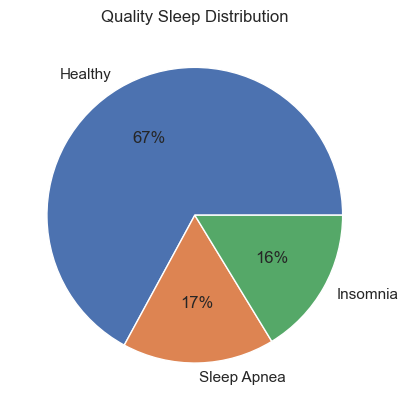

In [212]:
# Compter le nombre des valeurs distinctes des variables qualitatives
SleepDisorder = df["SleepDisorder"].value_counts()

plt.pie(SleepDisorder, labels = ["Healthy","Sleep Apnea","Insomnia"], autopct='%.0f%%') 
plt.title("Quality Sleep Distribution")


In [213]:
df.head()

,Gender,Age,Occupation,SleepDuration,QualitySleep,PhysicalActivityLevel,StressLevel,BMI_Category,BloodPressure,HeartRate,DailySteps,SleepDisorder
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,Healthy
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,Healthy
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,Healthy
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


Text(0.5, 1.0, 'Heart Rate')

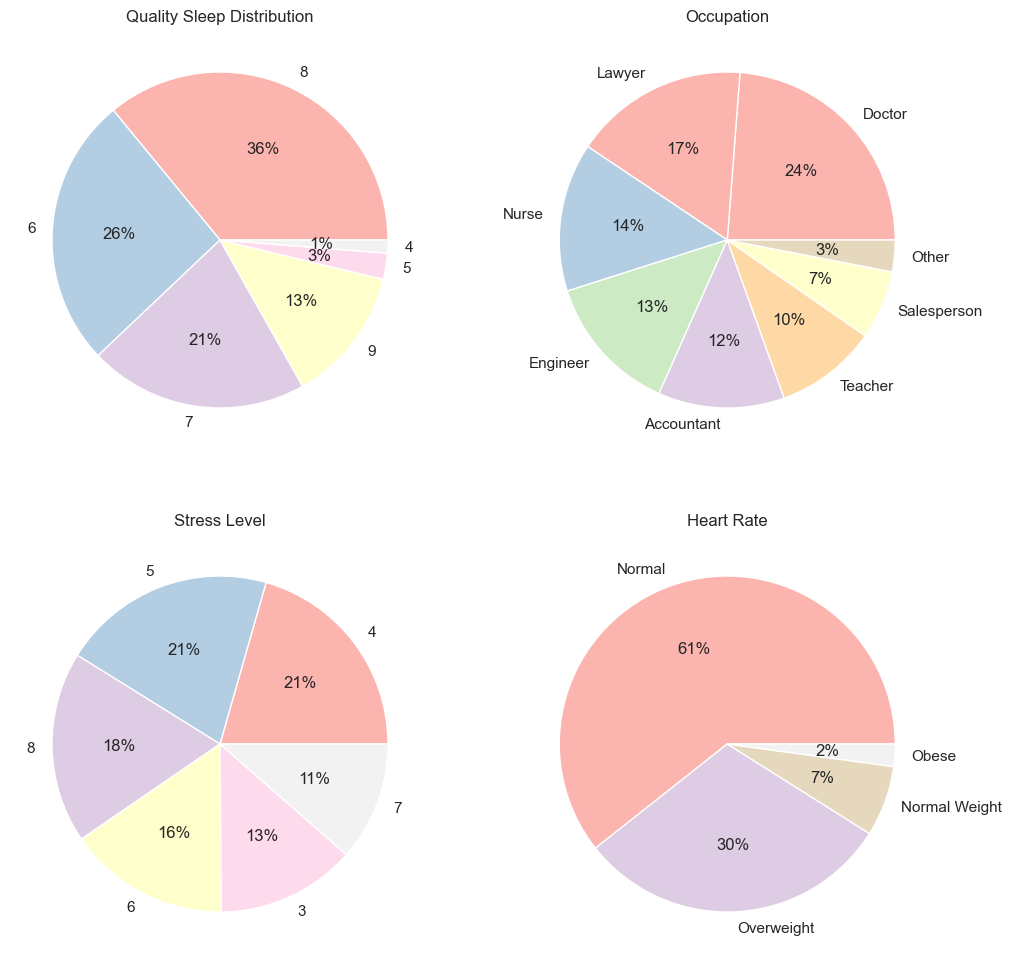

In [214]:
# Compter le nombre des valeurs distinctes des variables qualitatives
QualitySleep = df["QualitySleep"].value_counts()
Occupation = df["Occupation"].value_counts()
StressLevel = df["StressLevel"].value_counts()
BMI_Category = df["BMI_Category"].value_counts()

cmap = plt.get_cmap("Pastel1")
colors_QualitySleep = cmap(np.linspace(0, 1, len(QualitySleep)))
colors_Occupation = cmap(np.linspace(0, 1, len(Occupation)))
colors_StressLevel = cmap(np.linspace(0, 1, len(StressLevel)))
colors_BMI_Category = cmap(np.linspace(0, 1, len(BMI_Category)))

# Plotter le diagramme circulaire des variable explicatives
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0,0].pie(QualitySleep, labels = ["8","6","7","9","5","4"], autopct='%.0f%%', colors=colors_QualitySleep)
axes[0,0].set_title("Quality Sleep Distribution")
axes[0,1].pie(filtered_sizes_Occupation, labels = ["Doctor", "Lawyer", "Nurse", "Engineer", "Accountant", "Teacher", "Salesperson", "Other"], autopct='%.0f%%', colors=colors_Occupation)
axes[0,1].set_title("Occupation") 
axes[1,0].pie(StressLevel, labels = ["4", "5", "8", "6", "3", "7"], autopct='%.0f%%', colors=colors_StressLevel)
axes[1,0].set_title("Stress Level") 
axes[1,1].pie(BMI_Category, labels = ["Normal", "Overweight","Normal Weight", "Obese"], autopct='%.0f%%', colors=colors_BMI_Category) 
axes[1,1].set_title("Heart Rate")

In [215]:
# On a deux BMI_Category normales : "Normal Weight" et "Normal"
# On transforme les "Normal Weight" par "Normal"
df.replace("Normal Weight", "Normal", inplace=True)

# On sépare la tension en pression systolique et pression diastolique
for i in range(1,len(df)+1):
    pressure_list = df.loc[i,"BloodPressure"].split(sep='/')
    df.loc[i,"BloodPressureSystolic"] = int(pressure_list[0])
    df.loc[i,"BloodPressureDiastolic"] = int(pressure_list[1])
df.drop(columns="BloodPressure", inplace=True)

# On crée la liste des noms de variables quantitatives et qualitatives ordinales
quantitatives = ["Age", "SleepDuration", "PhysicalActivityLevel", "StressLevel", "QualitySleep",
                 "HeartRate", "DailySteps", "BloodPressureSystolic", "BloodPressureDiastolic"]

# On prépare une nouvelle colonne binaire pour les sujets sains et qui présentent un trouble du sommeil
encoding = {"Healthy": "Healthy", "Insomnia": "Unhealthy", "Sleep Apnea": "Unhealthy"} # 3 labels : sain, insomnie, apnée du sommeil
df["HasSleepDisorder"] = df["SleepDisorder"].map(encoding)

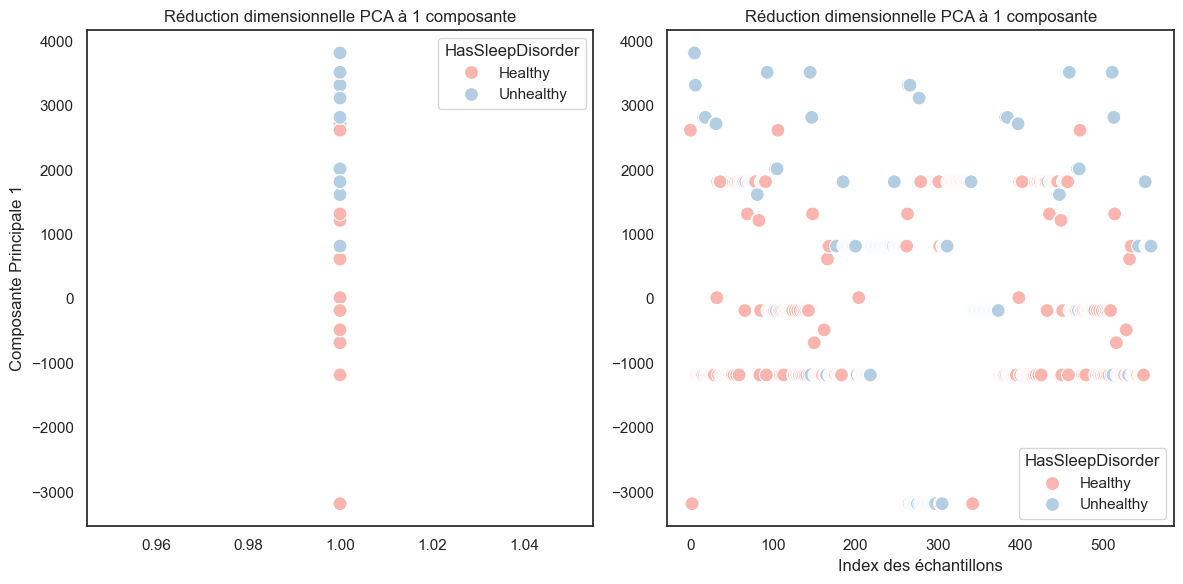

In [216]:
# Supposons que 'df' soit votre DataFrame
X = df[quantitatives]  # Caractéristiques (toutes les colonnes sauf la dernière)
y = df["HasSleepDisorder"]  # Colonne cible

# Appliquer PCA (1 composante)
acp1 = PCA(n_components=1, random_state=42).fit_transform(X)

# Créer un DataFrame avec les composantes principales
acp_df = pd.DataFrame(acp1, columns=['Composante Principale 1'])
acp_df['HasSleepDisorder'] = y

# Définir le style Seaborn avec un thème bleu (par exemple, 'whitegrid')
sns.set(style="white")  # Supprimer les lignes de la grille en utilisant le style 'white'

# Créer des sous-graphes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Graphe 1 : Nuage de points avec une valeur constante sur l'axe des X pour chaque échantillon
sns.scatterplot(x=np.ones(len(acp1)), y=acp1[:, 0], hue=y, palette="Pastel1", ax=axes[0], s=100)
axes[0].set_title('Réduction dimensionnelle PCA à 1 composante')
axes[0].set_ylabel('Composante Principale 1')

# Graphe 2 : Nuage de points avec l'index des échantillons sur l'axe des X
sns.scatterplot(x=range(len(acp1)), y=acp1[:, 0], hue=y, palette="Pastel1", ax=axes[1], s=100)
axes[1].set_title('Réduction dimensionnelle PCA à 1 composante')
axes[1].set_xlabel('Index des échantillons')

# Afficher le graphique
plt.tight_layout()  # Ajuster l'espacement entre les sous-graphes
plt.show()


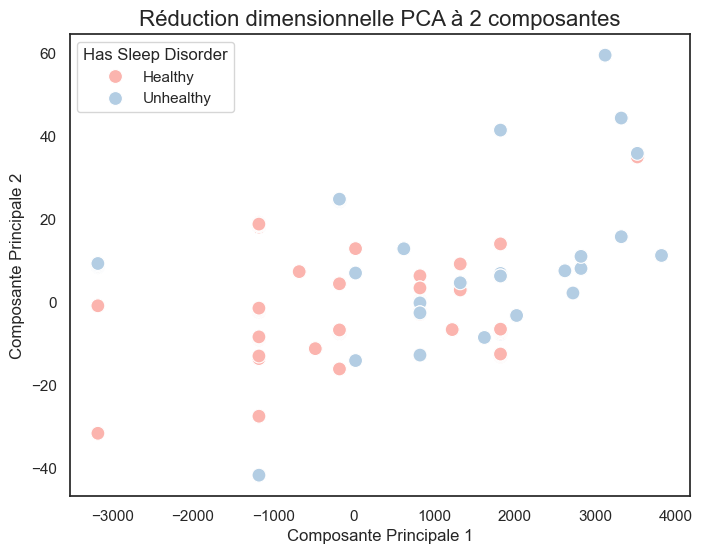

In [217]:
# Apply PCA (2 components)
acp = PCA(n_components=2, random_state=42).fit_transform(X)

# Create a DataFrame with PCA components
acp_df = pd.DataFrame(acp, columns=['Principal Component 1', 'Principal Component 2'])
acp_df['HasSleepDisorder'] = y

# Set Seaborn style to a blue theme (e.g., 'darkgrid')

# Create the Seaborn scatterplot with blue color palette
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='HasSleepDisorder',
                palette="Pastel1", data=acp_df, s=100)

# Customize the plot with titles and labels
plt.title('Réduction dimensionnelle PCA à 2 composantes', fontsize=16)
plt.xlabel('Composante Principale 1', fontsize=12)
plt.ylabel('Composante Principale 2', fontsize=12)
plt.legend(title='Has Sleep Disorder', loc='best')

# Display the plot
plt.show()

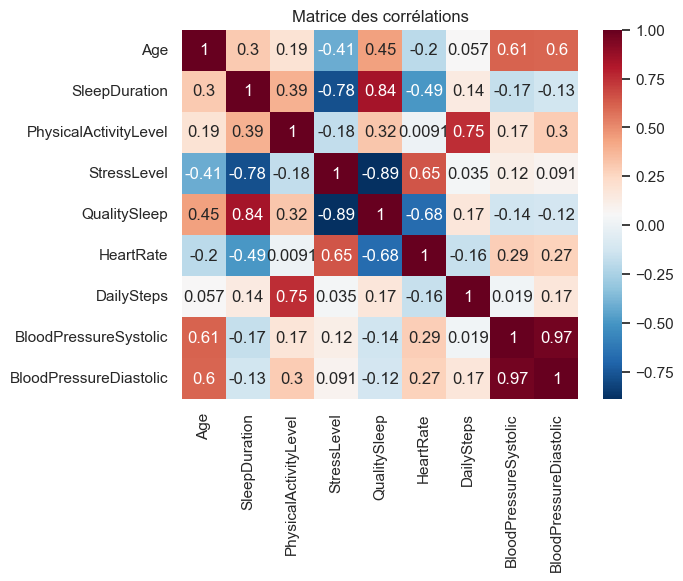

In [218]:
# On crée la matrice des corrélation pour les variables quantitatives et qualitatives ordinales
sns.heatmap(df[quantitatives].corr(), annot=True, cmap="RdBu_r")
plt.title("Matrice des corrélations")
plt.show()
# plt.savefig()

In [219]:
# Encodage de la variable à expliquer SleepDisorder
encoding = {"Healthy": 0, "Insomnia": 1, "Sleep Apnea": 2} # 3 labels : sain, insomnie, apnée du sommeil
df["SleepDisorderEncoded"] = df["SleepDisorder"].map(encoding)
encoding = {"Healthy": 0, "Insomnia": 1, "Sleep Apnea": 1} # 2 labels : avec vs sans trouble
df["HasSleepDisorder"] = df["SleepDisorder"].map(encoding)
df.drop(columns="SleepDisorder", inplace=True)

# Encodage des variables catégorielles
def OneHot(df, columns, except_one=False):
    '''
    One Hot Encoding pour une variable catégorielle.
    '''
    if except_one:
        for column in columns:
            for iter in df[column].unique()[:-1]:
                name = iter.replace(" ", "")
                df[name] = 0
                df.loc[df[column]==iter,name] = 1
    else:
        for column in columns:
            for iter in df[column].unique():
                name = iter.replace(" ", "")
                df[name] = 0
                df.loc[df[column]==iter,name] = 1
        
    df = df.drop(columns=columns, inplace=False)

    return df

df_all_encoded = OneHot(df, ["Gender", "Occupation", "BMI_Category"])
df_minimal_encoded = OneHot(df, ["Gender", "Occupation", "BMI_Category"], except_one=True)

# Découpage en train/test
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(df_all_encoded.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"]), 
                                                    df_all_encoded[["SleepDisorderEncoded","HasSleepDisorder"]], random_state=42,
                                                    stratify=df["SleepDisorderEncoded"])

X_train_minimal, X_test_minimal, y_train_minimal, y_test_minimal = train_test_split(df_minimal_encoded.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"]), 
                                                    df_minimal_encoded[["SleepDisorderEncoded","HasSleepDisorder"]], random_state=42,
                                                    stratify=df["SleepDisorderEncoded"])

# Full set notamment pour entraîner la forêt 
X_full_set_all = df_all_encoded.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"])
Y_full_set_all = df_all_encoded[["SleepDisorderEncoded","HasSleepDisorder"]]
X_full_set_minimal = df_minimal_encoded.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"])
Y_full_set_minimal = df_minimal_encoded[["SleepDisorderEncoded","HasSleepDisorder"]]

In [220]:
df_all_encoded.head()

,Age,SleepDuration,QualitySleep,PhysicalActivityLevel,StressLevel,HeartRate,DailySteps,BloodPressureSystolic,BloodPressureDiastolic,HasSleepDisorder,...,Nurse,Engineer,Accountant,Scientist,Lawyer,Salesperson,Manager,Overweight,Normal,Obese
1,27,6.1,6,42,6,77,4200,126.0,83.0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,6.2,6,60,8,75,10000,125.0,80.0,0,...,0,0,0,0,0,0,0,0,1,0
3,28,6.2,6,60,8,75,10000,125.0,80.0,0,...,0,0,0,0,0,0,0,0,1,0
4,28,5.9,4,30,8,85,3000,140.0,90.0,1,...,0,0,0,0,0,0,0,0,0,1
5,28,5.9,4,30,8,85,3000,140.0,90.0,1,...,0,0,0,0,0,0,0,0,0,1


ACP

In [221]:
df_all_encoded.head()

,Age,SleepDuration,QualitySleep,PhysicalActivityLevel,StressLevel,HeartRate,DailySteps,BloodPressureSystolic,BloodPressureDiastolic,HasSleepDisorder,...,Nurse,Engineer,Accountant,Scientist,Lawyer,Salesperson,Manager,Overweight,Normal,Obese
1,27,6.1,6,42,6,77,4200,126.0,83.0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,6.2,6,60,8,75,10000,125.0,80.0,0,...,0,0,0,0,0,0,0,0,1,0
3,28,6.2,6,60,8,75,10000,125.0,80.0,0,...,0,0,0,0,0,0,0,0,1,0
4,28,5.9,4,30,8,85,3000,140.0,90.0,1,...,0,0,0,0,0,0,0,0,0,1
5,28,5.9,4,30,8,85,3000,140.0,90.0,1,...,0,0,0,0,0,0,0,0,0,1


0.9214285714285714


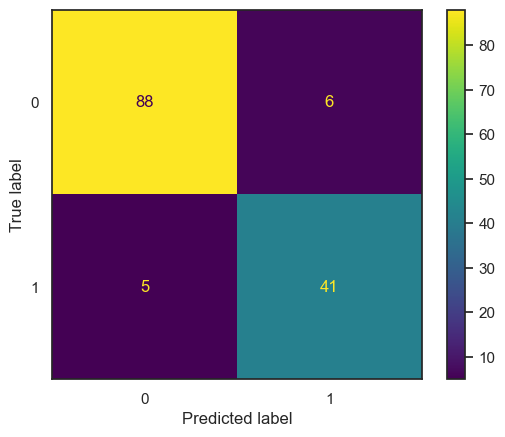

In [222]:
# On n'essaie que linéaire, beaucoup de variables catégorielles, les autres moins pertinentes
SVM_HAS = SVC(kernel="linear", max_iter=100000000, random_state=42).fit(X_train_all, y_train_all["HasSleepDisorder"])
pred_train = SVM_HAS.predict(X_train_all)
pred_test = SVM_HAS.predict(X_test_all)
print(len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test])/len(y_test_all))
cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

0.9


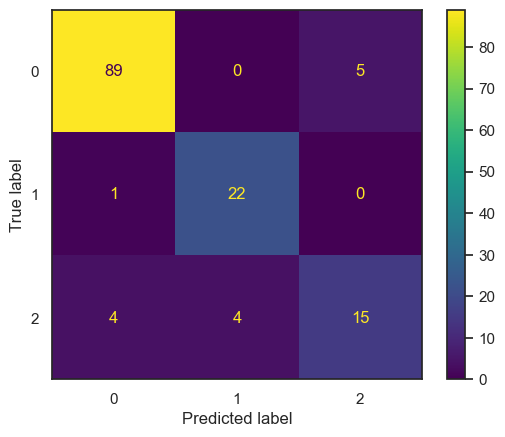

In [246]:
# On n'essaie que linéaire, beaucoup de variables catégorielles, les autres moins pertinentes#
SVM_MULTI = SVC(kernel="linear", max_iter=100000000, random_state=42).fit(X_train_all, y_train_all["SleepDisorderEncoded"])
pred_train = SVM_MULTI.predict(X_train_all)
pred_test = SVM_MULTI.predict(X_test_all)
print(len(y_test_all[y_test_all["SleepDisorderEncoded"]==pred_test])/len(y_test_all))
cm = confusion_matrix(y_test_all["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [369]:
TREE_MULTI = DecisionTreeClassifier(random_state=42).fit(X_train_all, y_train_all["SleepDisorderEncoded"])
pred_train = TREE_MULTI.predict(X_train_all)
pred_test = TREE_MULTI.predict(X_test_all)
print(len(y_test_all[y_test_all["SleepDisorderEncoded"]==pred_test])/len(y_test_all))
cm = confusion_matrix(y_test_all["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [370]:
TREE_MULTI = DecisionTreeClassifier(ccp_alpha=0.01, random_state=42).fit(X_train_all, y_train_all["SleepDisorderEncoded"])
pred_train = TREE_MULTI.predict(X_train_all)
pred_test = TREE_MULTI.predict(X_test_all)
print(len(y_test_all[y_test_all["SleepDisorderEncoded"]==pred_test])/len(y_test_all))
cm = confusion_matrix(y_test_all["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

Foret Aléatoire Validation croisée

In [225]:
FOREST_MULTI = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=1, min_samples_split=5, criterion = "entropy",
                                      random_state=42)
cv_scores = cross_val_score(FOREST_MULTI, X_train_all, y_train_all["HasSleepDisorder"], cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} ")

CV Accuracy: 0.9474 


Explication: 
Accuracy de la validation croisée est plus faible par rapport à l'outofbag ou sans aucune méthode car 0,95 est le meilleur accuracy qu'on peut obtenir après d'avoir appliqué tous les modèles dessus. par conséquent, le fait qu'on divise en K fold et moyenner les risques peut mélanger le meilleur modèle avec les modèle moins performants. On obtient donc un accuracy plus petit.

Estimer modèle Foret Aléatoire avec OOB 

In [245]:
FOREST_MULTI = RandomForestClassifier(n_estimators=100, max_features=1, oob_score=True, 
                                      criterion = "entropy", random_state=42).fit(X_train_all, y_train_all["HasSleepDisorder"])
# df_all_encoded
# Accéder au score OOB
oob_accuracy = FOREST_MULTI.oob_score_
print(f'Accuracy OOB : {oob_accuracy:.4f}')

Accuracy OOB : 0.9356


Explication: Comme la validation croisée, le meilleur modèle qu'on peut obtenir a 0.95 accuracy. Donc pour entrainer plusieurs arbres et faire la moyenne de OOB, l'accurary est surement baissé.


In [236]:
def Matrice_ROC_Var(model):
    model = model
    pred_train = model.predict(X_train_all)

    # Calculer un array de proba de prédiction pour la classe 1 et mettre un seuil pour customiser le modèle
    y_prob = model.predict_proba(X_test_all)[:, 1]
    pred_test = (y_prob > 0.5).astype(int)
    print("ACccuracy : ", len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test])/len(y_test_all))

    # Matrice de confusion
    cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test)
    
    # Créer subplot pour la Matrice de Confusion et la courbe ROC 
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plotter Matrice de Confusion
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues, ax=axes[0])
    axes[0].set_title("Matrice de Confusion")

    # Générer un courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test_all["HasSleepDisorder"], y_prob)

    # Computer Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.2f}")

    # Plot la courbe ROC
    axes[1].plot(fpr, tpr, color="blue", lw=2, label=f"Courbe ROC (AUC = {roc_auc:.2f})")
    axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1.5, label="Pile ou Face")
    axes[1].set_title("Courbe ROC")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend(loc="lower right")
    axes[1].grid(True)

    
    # Extraire les features importances
    feature_importances = model.feature_importances_

    # Create a DataFrame for feature importances
    features = pd.DataFrame({
        'Feature': X_train_all.columns,
        'Importance': feature_importances
    })

    # Selectionner le top 10 features les plus importants
    top_features = features.sort_values(by='Importance', ascending=False).head(10)

    # Plot les 10 features plus importants
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='Blues_r')
    plt.title('Top 10 Variables Importantes')
    plt.xlabel('Variables Importantes')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

ACccuracy :  0.95
AUC: 0.94


/var/folders/56/_dpbkklj7cbfxf4fl0w7bp380000gp/T/ipykernel_28953/49295009.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='Blues_r')


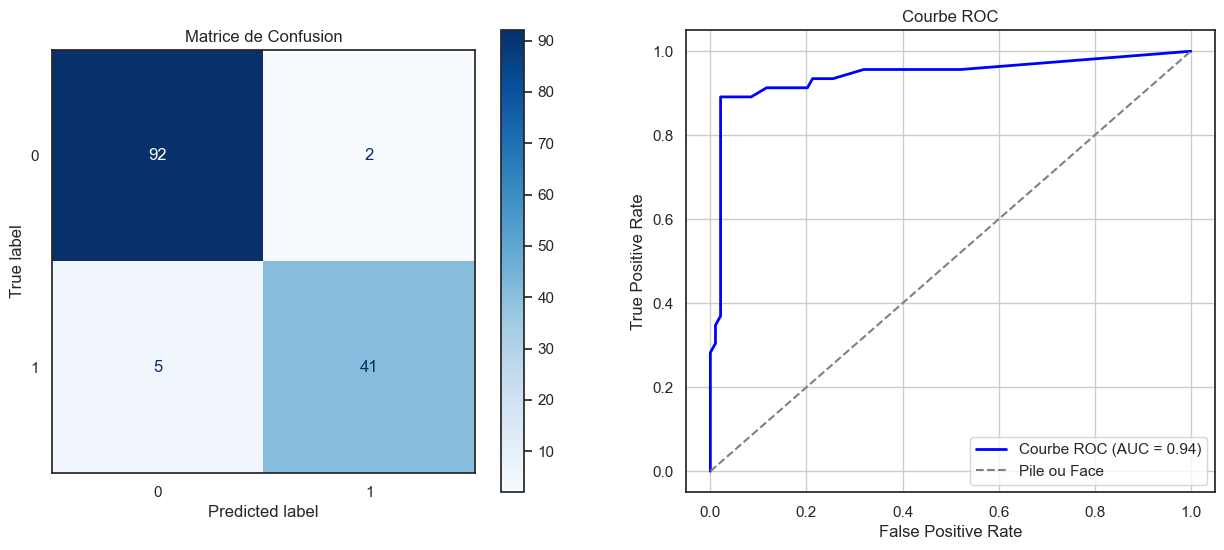

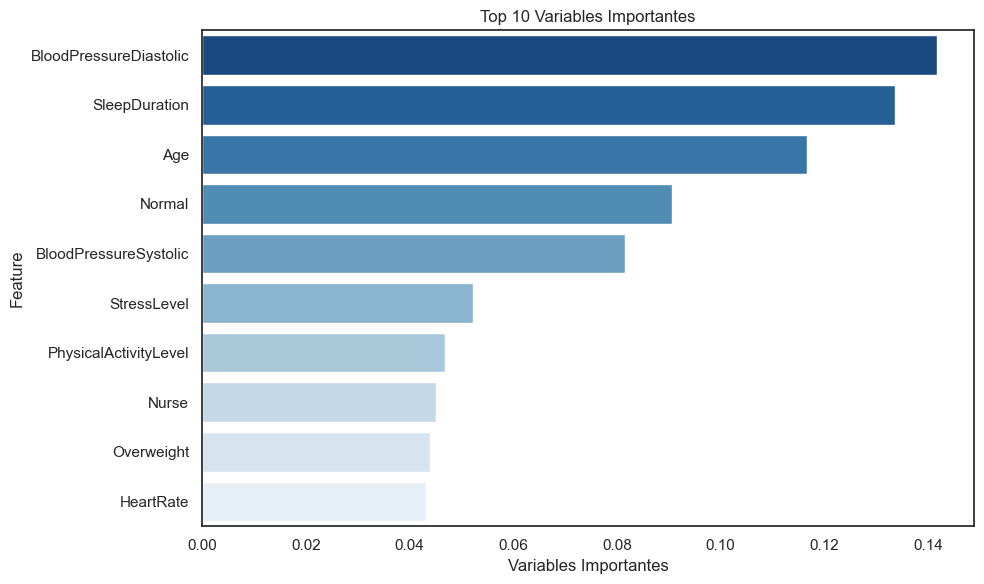

In [233]:
Matrice_ROC_Var(RandomForestClassifier(n_estimators=100, max_features=1, min_samples_split=5,  criterion = "entropy",
                                       random_state=42).fit(X_train_all, y_train_all["HasSleepDisorder"]))

Gridsearch

In [228]:
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [1,2,5,10,20,50,100,110,120,130],         
    'max_features' : [1,2,3,4,5,10,15],    
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                                    
    scoring='accuracy',        
)

grid_search.fit(X_train_all, y_train_all["HasSleepDisorder"])

# Meilleurs Paramtres trouvées par GridSearch
print("Best Parameters:", grid_search.best_params_)

# Meilleurs accuracy 
print("Best accuracy", grid_search.best_score_)


Best Parameters: {'max_depth': None, 'max_features': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best accuracy 0.9474182444061962


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1050 fits failed out of a total of 6300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1050 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/sit

In [385]:
# df_pred[(df_pred["Pred_HasSleepDisorder"] == 1) & (df_pred["Obese"] == 1)]
# df[(df["HasSleepDisorder"] == 1) & (df["Obese"] == 1)]
# # en données initiales, tous obeses ont le pb de sommeil

0.95


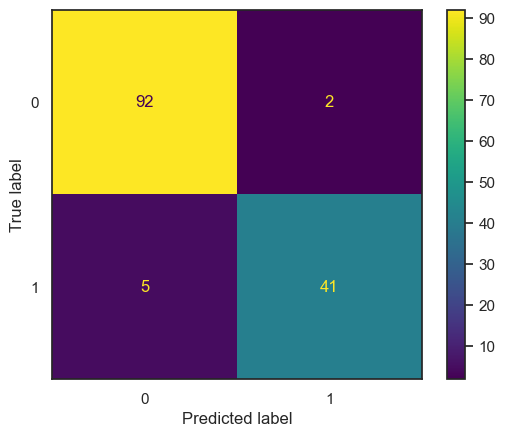

In [234]:
BOOSTING_MULTI = GradientBoostingClassifier(random_state=42).fit(X_train_all, y_train_all["HasSleepDisorder"])
pred_train = BOOSTING_MULTI.predict(X_train_all)
pred_test = BOOSTING_MULTI.predict(X_test_all)
print(len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test])/len(y_test_all))
cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [375]:
MLP_MULTI = MLPClassifier(hidden_layer_sizes=(16,), activation='relu', solver='adam', max_iter=1000, random_state=42)
MLP_MULTI.fit(X_train_all, y_train_all["SleepDisorderEncoded"])
pred_train = MLP_MULTI.predict(X_train_all)
pred_test = MLP_MULTI.predict(X_test_all)
print(len(y_test_all[y_test_all["SleepDisorderEncoded"]==pred_test])/len(y_test_all))
cm = confusion_matrix(y_test_all["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()